In [28]:
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import *
from keras.optimizers import Adam
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()


In [30]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape


((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [31]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

X_train = X_train.astype('float32')

# Scaling the range of the image to [-1, 1]
# Because we are using tanh as the activation function in the last layer of the generator
# and tanh restricts the weights in the range [-1, 1]
X_train = (X_train - 127.5) / 127.5

X_train.shape

(60000, 28, 28, 1)

In [32]:
generator = Sequential([
        Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)),
        BatchNormalization(),
        Reshape((7,7,128)),
        UpSampling2D(),
        Convolution2D(64, 5, 5, border_mode='same', activation=LeakyReLU(0.2)),
        BatchNormalization(),
        UpSampling2D(),
        Convolution2D(1, 5, 5, border_mode='same', activation='tanh')
    ])

/opt/conda/lib/python3.6/site-packages/Keras-2.1.5-py3.6.egg/keras/activations.py:115: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), activation=<keras.lay..., padding="same")`
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(1, (5, 5), activation="tanh", padding="same")`
  if __name__ == '__main__':


In [33]:
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 6272)              633472    
_________________________________________________________________
batch_normalization_3 (Batch (None, 6272)              25088     
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_4 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 28, 28, 64)        0         
__________

In [34]:
discriminator = Sequential([
        Convolution2D(64, 5, 5, subsample=(2,2), input_shape=(28,28,1), border_mode='same', activation=LeakyReLU(0.2)),
        Dropout(0.3),
        Convolution2D(128, 5, 5, subsample=(2,2), border_mode='same', activation=LeakyReLU(0.2)),
        Dropout(0.3),
        Flatten(),
        Dense(1, activation='sigmoid')
    ])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), input_shape=(28, 28, 1..., activation=<keras.lay..., strides=(2, 2), padding="same")`
  
/opt/conda/lib/python3.6/site-packages/Keras-2.1.5-py3.6.egg/keras/activations.py:115: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (5, 5), activation=<keras.lay..., strides=(2, 2), padding="same")`
  after removing the cwd from sys.path.


In [35]:
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 6273      
Total params: 212,865
Trainable params: 212,865
Non-trainable params: 0
_________________________________________________________________


In [36]:
generator.compile(loss='binary_crossentropy', optimizer=Adam())


In [38]:
discriminator.compile(loss='binary_crossentropy', optimizer=Adam())


In [39]:
discriminator.trainable = False
ganInput = Input(shape=(100,))
# getting the output of the generator
# and then feeding it to the discriminator
# new model = D(G(input))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(input=ganInput, output=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`
  


In [40]:
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 28, 28, 1)         865281    
_________________________________________________________________
sequential_4 (Sequential)    (None, 1)                 212865    
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


In [41]:
def train(epoch=10, batch_size=128):
    batch_count = X_train.shape[0] // batch_size
    
    for i in range(epoch):
        for j in tqdm(range(batch_count)):
            # Input for the generator
            noise_input = np.random.rand(batch_size, 100)
            
            # getting random images from X_train of size=batch_size 
            # these are the real images that will be fed to the discriminator
            image_batch = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]
            
            # these are the predicted images from the generator
            predictions = generator.predict(noise_input, batch_size=batch_size)
            
            # the discriminator takes in the real images and the generated images
            X = np.concatenate([predictions, image_batch])
            
            # labels for the discriminator
            y_discriminator = [0]*batch_size + [1]*batch_size
            
            # Let's train the discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_discriminator)
            
            # Let's train the generator
            noise_input = np.random.rand(batch_size, 100)
            y_generator = [1]*batch_size
            discriminator.trainable = False
            gan.train_on_batch(noise_input, y_generator)

In [42]:
train(30, 128)


100%|██████████| 468/468 [00:36<00:00, 12.88it/s]


In [43]:
generator.save_weights('gen_30_scaled_images.h5')
discriminator.save_weights('dis_30_scaled_images.h5')

In [44]:
train(20, 128)


100%|██████████| 468/468 [00:36<00:00, 12.72it/s]


In [45]:
generator.save_weights('gen_50_scaled_images.h5')
discriminator.save_weights('dis_50_scaled_images.h5')

In [46]:
generator.load_weights('gen_50_scaled_images.h5')
discriminator.load_weights('dis_50_scaled_images.h5')

In [47]:
def plot_output():
    try_input = np.random.rand(100, 100)
    preds = generator.predict(try_input)

    plt.figure(figsize=(10,10))
    for i in range(preds.shape[0]):
        plt.subplot(10, 10, i+1)
        plt.imshow(preds[i, :, :, 0], cmap='gray')
        plt.axis('off')
    
    # tight_layout minimizes the overlap between 2 sub-plots
    plt.tight_layout()

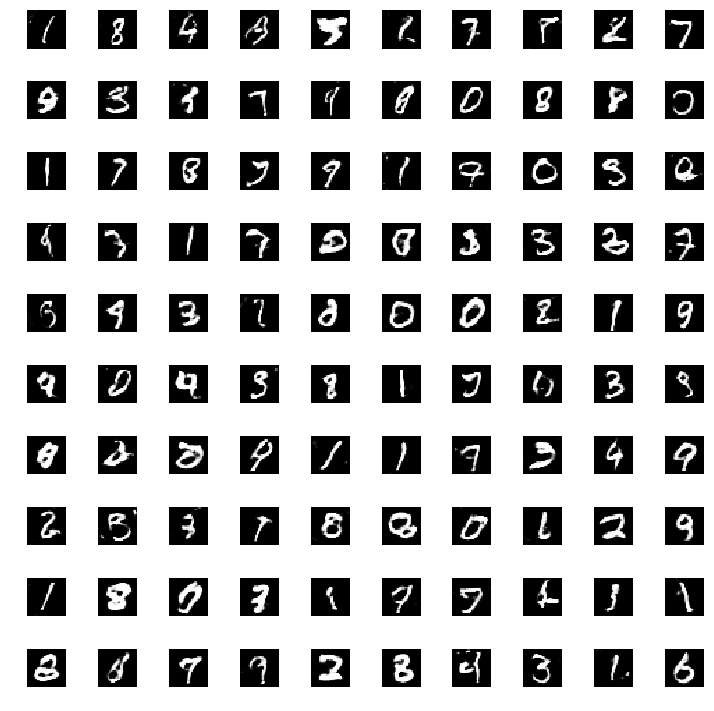

In [48]:
plot_output()